In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import matplotlib.patches as mpatches
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
red_wine["type"]=1
white_wine["type"]=0
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: "low" if value<=5 else "medium" if value< 7 else "high")
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: "low" if value<=5 else "medium" if value< 7 else "high")
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=["low","medium","high"])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=["low","medium","high"])
#Combining the two wine databases
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [6]:
#FUNCTIONS
#Frequency analysis for specific feature on both types
def freq(x):
    fig,axes=plt.subplots(nrows=1,ncols=2,sharey=True,sharex=True,figsize=(10,4),facecolor="snow")
    wines.hist(column=x,by="type",ax=axes,color="crimson",edgecolor="black",linewidth=1)
    x=x.replace("_"," ")
    x=x.capitalize()
    fig.supxlabel(x)
    x+=" content in wines"
    plt.suptitle(x,x=0.5,y=1.05,ha="center",fontsize="x-large")
    fig.supylabel("Frequency")
    axes[0].set_title("Red Wines")
    axes[1].set_title("White Wines")
#Creates a boxplot for variables xy to z of winetype dataset. If out==False removes outliers
def boxplotter(x,y,z,winetype,out):
    fig, axes = plt.subplots(1,2, figsize=(10,10),facecolor="snow")
    temp=winetype[[z,x]]
    temp.boxplot(by=z, ax=axes[0],showfliers=out,color="dimgray");axes[0].set_title(""); axes[0].set_xlabel(z); axes[0].set_ylabel(x)
    temp=winetype[[z,y]]
    temp.boxplot(by=z, ax=axes[1],showfliers=out,color="dimgray");axes[1].set_title(""); axes[1].set_xlabel(z); axes[1].set_ylabel(y)
#Normalizes a dataset
def normalizer(df): 
    df=df.drop(["type","quality_label"],axis=1)
    scaler=MinMaxScaler()
    scaler.fit(df)
    scaled=scaler.fit_transform(df)
    scaled_df=pd.DataFrame(scaled,columns=df.columns)
    return scaled_df
#Takes a,b variables for x and y axis respectively; nor is a boolean value for normalization
def plotter(a,b,c,d,nor):
    if nor:
        c=normalizer(c)
        d=normalizer(d)
    fig, axes = plt.subplots(1,2, figsize=(14,7),facecolor="snow")
    x=sns.regplot(ax=axes[0],x=c[a],y=c[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    y=sns.regplot(ax=axes[1],x=d[a],y=d[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    return x,y
#Graphs relationship between x,y variables on df dataset
def rel_check(x,y,df):
    gg=sns.JointGrid(x=x,y=y,data=df)
    gg=gg.plot_joint(sns.regplot,color="crimson")
    gg=gg.plot_marginals(sns.histplot,kde=True,color="goldenrod")
    return gg
#Multigraphs kde,scatter and hist for all variables (It takes time)
def exp(df):
    pp = sns.PairGrid(df)
    pp = pp.map_upper(sns.kdeplot,cmap="hot",shade=True,thresh=False)
    pp = pp.map_diag(plt.hist,color="darkgrey")
    pp = pp.map_lower(sns.scatterplot,color="crimson",edgecolor="black")
    return pp
#Used for the removal of outliers
def correction(df):
    labels=["fixed_acidity","volatile_acidity","citric_acid","residual_sugar","chlorides","free_sulfur_dioxide","total_sulfur_dioxide","density","sulphates","alcohol","quality"]
    sorted(df)
    for i in labels:
        q1=df[i].quantile(0.25)
        q3=df[i].quantile(0.75)
        iqr=q3-q1
        low=q1-1.5*iqr
        high=q3+1.5*iqr 
        df=df.loc[(df[i]>low) & (df[i]<high)]
    return df
#Multivariate analysis with x,y features of df dataset, with quality label hue
def multivariate(x,y,df):
    colors={"low":"yellow","medium":"crimson","high":"black"}
    fig,axes=plt.subplots(figsize=(12,8),facecolor="snow")
    scatter=axes.scatter(df[x],df[y],c=df["quality_label"].map(colors),alpha=0.5)
    x=x.replace("_"," ").capitalize()+", "
    axes.set_xlabel(x,fontsize=10)
    y=y.replace("_"," ")+" "
    axes.set_ylabel(y,fontsize=10)
    if len(df["type"].unique())==2: title="Wines"
    elif 1 in df["type"].unique(): title="Red wines"
    else: title="White wines" 
    axes.set_title(title+" - "+x +y+ "and quality")
    low_quality=mpatches.Patch(color="yellow",label="Low quality wines")
    medium_quality=mpatches.Patch(color="crimson",label="Medium quality wines")
    high_quality=mpatches.Patch(color="black",label="Higher quality wines")
    axes.legend(handles=[low_quality,medium_quality,high_quality])
    plt.show()

In [273]:
#Solving for times*0.05*std from any variable x's mean; so that at least 75% is of a particular quality or high label
#Returns the wines within the greatest range and the times 
def expanding_circles(x,df,rank,labels):
    per=[3,4,5,6,7,8,9]
    ind=rank-3
    incr=0.05
    times=0
    marker="quality"
    if labels:
        per=["low","medium",1]
        ind=2
        rank="high"
        marker="quality_label"
    while per[ind]>=0.75:
        temp=df.loc[(df[marker]==rank)]
        high_mean=temp[x].mean()
        high_std=temp[x].std()
        upper_bound=high_mean+incr*high_std
        lower_bound=high_mean-incr*high_std
        incr+=0.05
        times+=1
        temp=(df.loc[(df[x]<upper_bound)&(df[x]>lower_bound)])
        per=(temp[marker].value_counts(normalize=True))
        a=(df.loc[(df[x]<upper_bound)&(df[x]>lower_bound)])
        return a,times


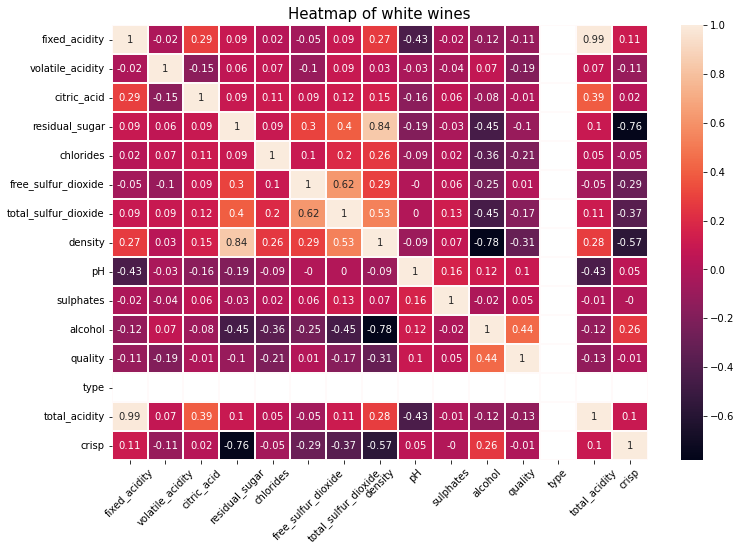

,quality
quality,1.000000
alcohol,0.435575
pH,0.099427
sulphates,0.053678
free_sulfur_dioxide,0.008158
citric_acid,-0.009209
crisp,-0.013264
residual_sugar,-0.097577
fixed_acidity,-0.113663
total_acidity,-0.131377


In [291]:
a=white_wine
a["total_acidity"]=a.volatile_acidity+a.fixed_acidity+a.citric_acid
a["crisp"]=a.total_acidity/a.residual_sugar
plt.figure(figsize=(12,8))
sns.heatmap(a.corr().round(2),color="k",linecolor="snow",linewidth=0.2,annot=True)
plt.xticks(rotation=45)
plt.title("Heatmap of white wines", fontsize=15)
plt.show()
a.corr()[["quality"]].sort_values(by="quality",ascending=False)

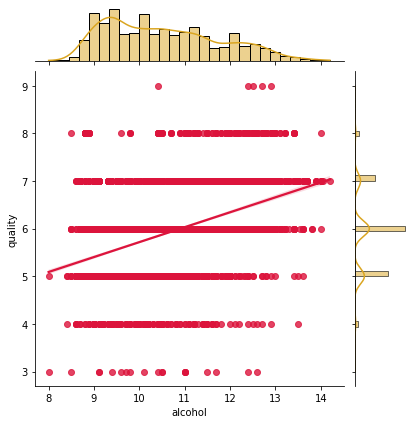

In [298]:
rel_check("alcohol","quality",white_wine)